# <u>NSW DCCEEW training – Demo 3: data visualisation</u>

 - <b>Author</b>: Eric.Lehmann@csiro.au
 - <b>Release date / version</b>: Aug. 2024, v1.0
 - <b>Dev. platform</b>: CSIRO ADIAS/ADS (hub.adias.aquawatchaus.space)
 - <b>Server profile</b>: EASI Open Data Cube No ML &ndash; Version 2023.10.2 
 - <b>Server resources</b>: 32 CPU &ndash; 64GB RAM
 - <b>Python kernel</b>: `Python 3 (ipykernel)`
 - <b>Dask</b>: Gateway cluster &ndash; 8 workers @ 4GB MEM each


<b>Contents</b>
  - [Overview](#Overview)
  - [User parameters](#User-parameters)
  - [Notebook setup](#Notebook-setup)
  - [Dask](#Dask)
  - [Data loading, pre-processing, TSS calculation](#Data-loading,-pre-processing,-TSS-calculation) 
  - [Visualisation](#Visualisation)
  - [Teasers](#Teasers)
  

# Overview

This series of notebooks (`NSW DCCEEW training`) provides a demonstration of some basic analyses of water quality parameter (TSS) using Landsat data (Acolite processed).

  - Demonstration notebooks
    - For audience with various skills levels
    - Get a feel for EASI / ADIAS and ODC technology
  - Demonstrates some interesting science:
    - Calculation of empirical algorithms for water quality parameters (TSS)
    - Basic statistical and trends analyses
    - Calculation of sediment flux using BoM rainfall data
  - Touches on various technical aspects:
    - JupyterLab environment and notebooks
    - Data availability and access on ADIAS and elsewhere
    - Visualisation
    - Parallelism and parallelised processing
 
# User parameters

In [1]:
### Selected river systems: lat/lon locations
riv_loc =  (151.34428, -33.5677)   # selected location -- river mouth, Haweksbury

min_longitude, max_longitude = (151.1355, 151.7047)   # ROI for visualisation purposes
min_latitude, max_latitude = (-33.8025,-33.3707)

# time_range = ('2013-01-01','2025-01-01')   # selected time window: FULL LANDSAT TIME SERIES!! (not needed for this demo)
time_range = ('2022-01-01','2024-01-01')   # selected time window

### Selected parameter to plot / visualise 
# Note: various WQ parameters can be theoretically selected for analysis in the code below. However,
# the flux calculations at the end of this notebook will fail for WQ units other than 'mg/L'.
WQparam = 'TSS'          # selected WQ parameter
WQunits = 'mg/L'         # WQ units
lower_is_better = True   # whether lower WQ values are blue/red in plots
wq_log_scale = True      # whether to plot raw WQ values in log-scale

# n_workers = None    # for local Dask cluster
n_workers = 8; workers_mem = 4    # for Dask Gateway cluster

# Notebook setup

In [2]:
### System
import sys, os
import itertools

### Data handling
import pyproj
import numpy as np
import xarray as xr
from astropy.stats import sigma_clip
import statsmodels.api as sm

import rioxarray
import rasterio
import rasterio.features
import geopandas as gpd
import pandas as pd

from shapely.affinity import translate
from shapely.geometry import Polygon
import xml.etree.ElementTree as ET

### ODC / STAC
import odc.stac
import pystac_client

### Data cube
import datacube
dc = datacube.Datacube(app="NSW_demo")

### Dask
from dask.distributed import wait

### Display / plots
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap

In [3]:
import hvplot.xarray
import xarray as xr
import numpy as np
import pandas as pd
import panel as pn
import holoviews as hv
from matplotlib.colors import LinearSegmentedColormap

pn.extension()

Here making use of a couple of functions from the base EASI notebooks &ndash; these can be accessed by `git clone`-ing the following repo: `https://github.com/csiro-easi/easi-notebooks.git`

In [4]:
### Misc
sys.path.append('/home/jovyan/git_hub_notebooks/scripts/')
import notebook_utils   # for xarray_object_size(), localcluster_dashboard()
from app_utils import display_map

exec(open("./get_coastline.py").read())

In [5]:
if lower_is_better: 
    cmap = 'jet'
    cmap1 = 'RdBu_r'   # 'coolwarm': centre colour is grey -- 'RdBu_r': centre colour is white
else: 
    cmap = 'jet_r'
    cmap1 = 'RdBu'
    
if wq_log_scale: norm = colors.LogNorm()
else: norm = None

cmp = LinearSegmentedColormap.from_list("cmp", ["gainsboro", "gainsboro"])   # "dummy" colormap for greyed out land pixels

In [6]:
import warnings

### Filter out following warnings:
# /env/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 32.04 MiB.
# This may cause some slowdown. Consider scattering data ahead of time and using futures.
warnings.filterwarnings("ignore", category=UserWarning)

# warnings.resetwarnings()

In [7]:
from collections import Counter

def mostcommon_crs_res(dc, query):
    # Returns the most common CRS and resolution for a given DC query.
    # Adapted from 'mostcommon_crs()' from 'notebook_utils'
    """Adapted from https://github.com/GeoscienceAustralia/dea-notebooks/blob/develop/Tools/dea_tools/datahandling.py"""
    matching_datasets = dc.find_datasets(**query)
    crs_list = [str(i.crs) for i in matching_datasets]
    resx_list = [i.metadata_doc['grids']['default']['transform'][0] for i in matching_datasets]   # x-res
    resy_list = [i.metadata_doc['grids']['default']['transform'][4] for i in matching_datasets]   # y-res
    
    crs_mostcommon = None
    res_mostcommon = None
    if len(crs_list) > 0:
        # Identify most common CRS + resolution
        crs_counts = Counter(crs_list)
        crs_mostcommon = crs_counts.most_common(1)[0][0]
        
        resx_counts = Counter(resx_list)
        resy_counts = Counter(resy_list)
        res_mostcommon = (resx_counts.most_common(1)[0][0], resy_counts.most_common(1)[0][0])
    else:
        logger.warning('No data was found for the supplied product query')
    return crs_mostcommon, res_mostcommon

# Dask

Flexible open-source library for parallel and distributed computing in Python. It provides integration with various Python libraries like NumPy, Pandas, and scikit-learn to enable parallel execution across multiple cores.

In [8]:
### Local Dask cluster
if n_workers is None:  # local Dask cluster using all available CPUs
    
    from dask.distributed import Client, LocalCluster
    # sys.path.append('/home/jovyan/git_hub_notebooks/scripts/')
    # import notebook_utils   # for localcluster_dashboard()

    cluster = LocalCluster()
    client = Client(cluster)

    print(f"Local cluster dashboard: {notebook_utils.localcluster_dashboard(client,server='https://hub.adias.aquawatchaus.space')}")
    display(cluster)

### Use the following to shut down this cluster:
# cluster.close()
# client.shutdown()

In [9]:
### Dask Gateway cluster @ n_workers
if n_workers is not None:

    from dask_gateway import Gateway
    gateway = Gateway()
    
    # shutdown_all_clusters...
    clusterRpts = gateway.list_clusters()
    if len(clusterRpts)>0: print(f"Shutting down running clusters:\n {clusterRpts}")
    for cluster in clusterRpts:
        c = gateway.connect(cluster.name)
        c.shutdown()

    print("Creating new Gateway cluster...")

    options = gateway.cluster_options()
    options.node_selection = "worker" 
    options.worker_cores = 8
    options.worker_memory = workers_mem

    cluster = gateway.new_cluster(cluster_options=options)
    cluster.scale(n_workers)
    display( cluster )

    ### Wait for all workers to start
    client = cluster.get_client()
    display( client )
    client.sync( client._wait_for_workers, n_workers=n_workers )

### Use the following to shut down this cluster:
# cluster.shutdown()
# client.close()

Creating new Gateway cluster...


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.adias.aquawatchaus.space/services/dask-gateway/clusters/easihub.faaa5d23ee204e45be15cc389cb43b22/status,


In [10]:
display_map(x=(min_longitude,max_longitude), y=(min_latitude,max_latitude))

# Data loading, pre-processing, TSS calculation

Refer to the first notebook in this series (`demo01`) for more info if needed!

Overview of the Landsat data on ADS: https://explorer.adias.aquawatchaus.space/products/landsat8_c2_acolite_ar and https://explorer.adias.aquawatchaus.space/products/landsat9_c2_acolite_ar


In [11]:
LS_band_aliases = ['SR_B1','SR_B3','SR_B5','SR_B7','SR_B8']   # some bands for demo purpose...
chunking = {'x': 512, 'y': 512, 'time': 1}

query = { 'product': ('landsat8_c2_acolite_ar','landsat9_c2_acolite_ar'),    # Landsat products
          'longitude': (min_longitude, max_longitude),    # "x" axis bounds
          'latitude': (min_latitude, max_latitude),      # "y" axis bounds
          'time': time_range,                       # Any parsable date strings
          'group_by': 'solar_day',                # Scene ordering
          'measurements': LS_band_aliases }  # Landsat8/9 bands

mc_crs, mc_res = mostcommon_crs_res(dc, query)   # Landsat datasets' native CRS and resolution
query.update( output_crs=mc_crs, 
              dask_chunks=chunking, 
              resolution=mc_res,
              resampling={'*':'average', 'l2_flags':'nearest'} )   # average resampling leads to least amount of missing pixels
_ = query.pop('product')   # dc.load() not (supposed to be) able to load multiple products...

In [12]:
%%time

data_ls8 = dc.load( product='landsat8_c2_acolite_ar', **query ).persist()
_ = wait(data_ls8)

data_ls9 = dc.load( product='landsat9_c2_acolite_ar', **query ).persist()
_ = wait(data_ls9)

CPU times: user 1.27 s, sys: 98.8 ms, total: 1.37 s
Wall time: 2min 15s


In [13]:
### Merge LS8 and LS9 datasets
data = xr.concat([data_ls8, data_ls9], dim="time", compat='identical').sortby("time").persist()
_ = wait(data)

### Apply conversion and empirical WQ algorithms.
data = data * 1.0301 - 0.00001   # applied to each band
data = data.where(data>0)   # filter out negative SR values

data['TSS'] = 1.1486 * pow(data.SR_B3 / data.SR_B1, 0.7053)

### Remove SR bands (not required any longer)
# data = data.drop(LS_band_aliases).persist()

### Remove any time slice that only contains NaNs
data = data.dropna('time',how='all').persist()
_ = wait(data)

tmp = data.time.values
date_start = tmp[0].astype('datetime64[D]')
date_end = tmp[-1].astype('datetime64[D]')

In [14]:
### Generate coastline and land mask for current extents, in projected CRS
tmp = data.TSS[0].rio.reproject('EPSG:4326').rename({'x':'longitude','y':'latitude'})

offset = (-0.006,-0.001)   # fix apparent mis-alignment coastline vs. Landsat (...?!??)
land_mask, shp_poly = get_coastline( ds_lon_vec=tmp.longitude.values, ds_lat_vec=tmp.latitude.values, offset=offset)   #, do_plot=True)#, buf=0.2 )

land_mask.rio.write_crs('EPSG:4326', inplace=True)
land_mask = land_mask.rio.reproject_match( data )
shp_poly = shp_poly.set_crs('EPSG:4326').to_crs(mc_crs)

# Visualisation

In [15]:
data

<xarray.Dataset>
Dimensions:      (time: 75, y: 1624, x: 1787)
Coordinates:
  * time         (time) datetime64[ns] 2022-01-14T23:43:56.509750 ... 2023-04...
  * y            (y) float64 -3.742e+06 -3.742e+06 ... -3.693e+06 -3.693e+06
  * x            (x) float64 3.801e+05 3.801e+05 ... 3.266e+05 3.265e+05
    spatial_ref  int32 32656
Data variables:
    SR_B1        (time, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SR_B3        (time, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SR_B5        (time, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SR_B7        (time, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SR_B8        (time, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    TSS          (time, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes:
    crs:           epsg:32656
    grid_mapping:  spatial_ref

In [16]:
log_scale = False   # use log-scale (or not) in the map plot
cmap = 'jet'        # colour map for the map plot

plot_height = 600   # height of the plot in the notebook
prc_clip = 98.0     # percentage for 'manual' data clipping in 'robust'-like plots

In [29]:
pclip2 = (100.-prc_clip)/2
tmp = data.sizes
options = { 'frame_width':  int(plot_height * tmp['x'] / tmp['y']), 'frame_height': plot_height,
            'aspect': 'equal', 'cmap': cmap, 'colorbar': True, 'logz': log_scale }

# Create Panel widgets for the sliders: 
tmp = data.time.dt.strftime('%Y-%m-%d').values.tolist()
time_slider = pn.widgets.Select(options=tmp, name='Time Slice')

tmp = list(data.data_vars)
variable_slider = pn.widgets.Select(options=tmp, name='Variable')

# Create a function to update the plot dynamically:
def update_plot(selected_date_sat, selected_variable):
    tmp = data.time.dt.strftime('%Y-%m-%d').values
    index_time = np.where(tmp==selected_date_sat)[0][0]  # retrieve time index from selected drop-down item
    disp_data = data[selected_variable].isel(time=index_time)
    # lim1,lim2 = np.nanpercentile(disp_data.values, [pclip2,100.-pclip2])
    lim1,lim2 = disp_data.chunk(dict(y=-1,x=-1)).quantile([0.05,0.95],dim=['x','y']).values
    title = f'{selected_variable} map for {selected_date_sat}'
    return disp_data.hvplot.image( y='y', x='x', title=title, clim=(lim1, lim2), framewise=False, rasterize=True ).opts(**options)   
        # rasterize=True --> allows for re-rendering/rastering on zoom/pan...

# Link the sliders to the update_plot function:
pnplot = pn.bind(update_plot, selected_date_sat=time_slider, selected_variable=variable_slider)

# Combine the sliders and the plot:
# dyn_map = hv.DynamicMap( pnplot )
# pn.Row(dyn_map, pn.Column(time_slider, variable_slider))
pn.Row(pnplot, pn.Column(time_slider, variable_slider))   # allows for re-rendering/rastering on zoom/pan...

Row
    [0] ParamFunction(function, _pane=HoloViews, defer_load=False)
    [1] Column
        [0] Select(name='Time Slice', options=['2022-01-14', ...], value='2022-01-14')
        [1] Select(name='Variable', options=['SR_B1', 'SR_B3', ...], value='SR_B1')

# Teasers

More display tricks possible, e.g. click on the map and display corresponding spectrum data...

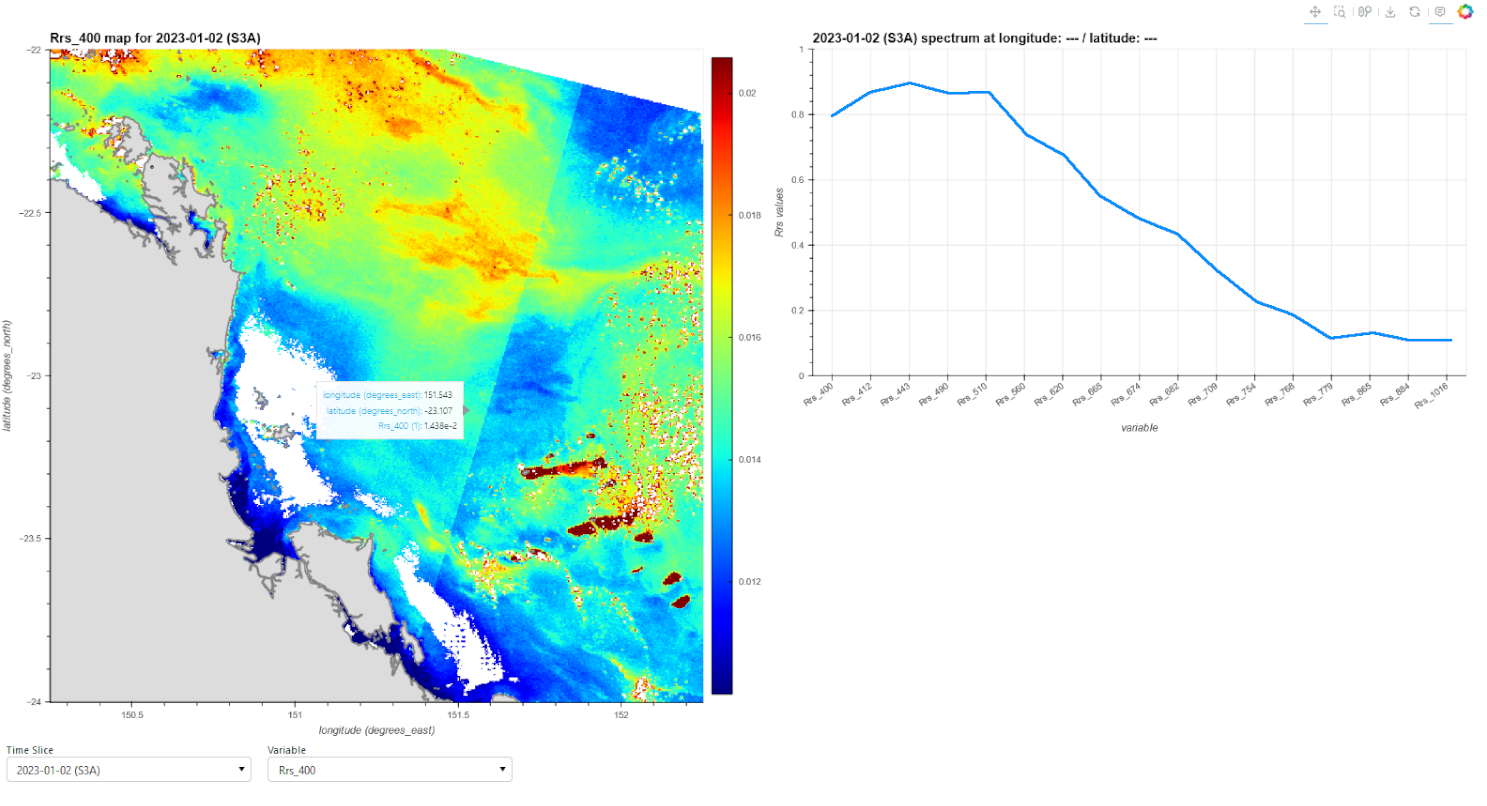

Another example: parallel linked plots (synchronous pan and zoom)...

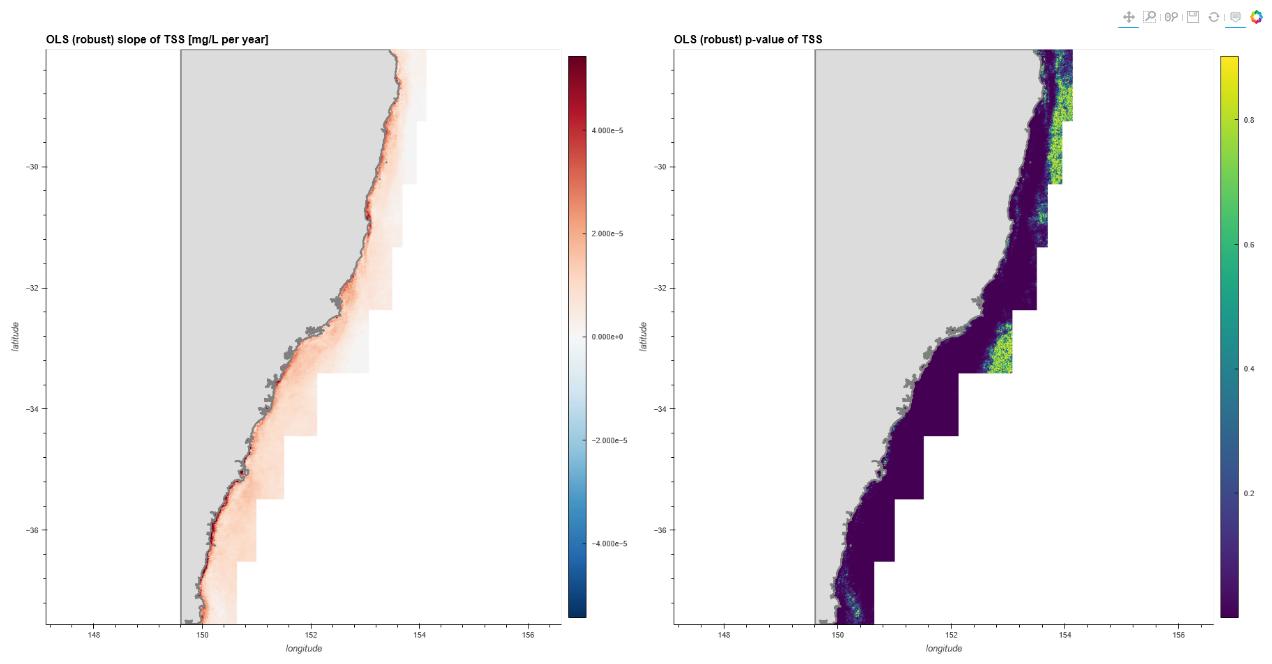

In [18]:
### End notebook.